In [1]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.main import FBRestNet
from FBResNet.model import MyModel
from FBResNet.posttreat import Export_hyper

In [2]:
exp1 = FBRestNet(experimentation=Physics(2000,50,0.5,1), constraint = 'slab',\
                 nb_blocks=20, noise = 0.05,\
                 folder = './', im_set="Set1",batch_size=[600,1],\
                 lr=1e-3, nb_epochs=[30,1])

In [3]:
train_set, val_set = exp1.CreateDataSet()

In [4]:
# exp1.train(train_set,val_set,save_model=True)
# load parameters
exp1.LoadParam()

### Gaussian

### Lipschitz

In [5]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.04936090856790525

In [6]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

0.0

### Testing set

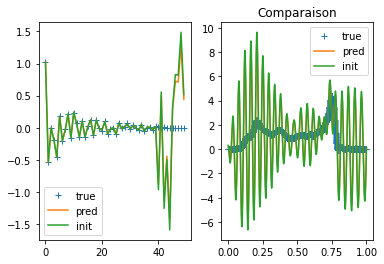

Erreur relative :  3.880140250903868


In [7]:
l_i, l_t, l_p = exp1.test(val_set)

In [8]:
# exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.04933967049843626

In [9]:
# exp1.model.Lipschitz(opt1="semi",opt2="entree01")

7.547491081718631e-06

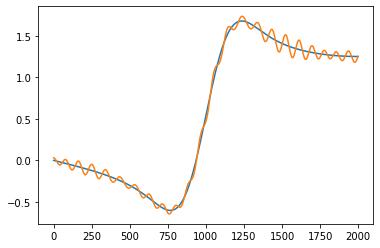

<class 'str'>
x-xp/x = 0.1745116730693435


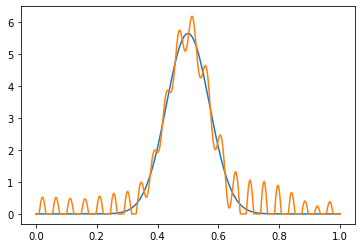

In [16]:
exp1.test_gauss()

### TEST ON OTHER FUNCTIONS

In [11]:
import pandas as pd
folder = './Datasets/Signals'
dfl  = pd.read_csv(folder+'/'+'data_l_trsf_a1_slab.csv', sep=',',header=None)
dfle = pd.read_csv(folder+'/'+'data_l_a1_slab.csv', sep=',',header=None)
dfb  = pd.read_csv(folder+'/'+'data_b_a1_slab.csv', sep=',',header=None)
dfbn = pd.read_csv(folder+'/'+'data_bn_a1_slab.csv', sep=',',header=None)
dfTbn = pd.read_csv(folder+'/'+'data_tTb_a1_slab.csv', sep=',',header=None)
# numpy array
fl = np.array(dfl)
fle = np.array(dfle) # initial - elt basis
fb = np.array(dfb)
fbn = np.array(dfbn)
fTbn = np.array(dfTbn)

In [12]:
# Select 3 curves number 15, 24, 30
x_true = fle[15]
x = torch.FloatTensor(fle[15]).view(-1,1,exp1.physics.m)
y = torch.FloatTensor(fTbn[15]).view(-1,1,exp1.physics.m)

In [13]:
x_bias  = Variable(y,requires_grad=False)
# definition of the initialisation tensor
x_init   = torch.zeros(x_bias.size())
inv      = np.diag(exp1.physics.eigm**(2*exp1.physics.a))
tTTinv   = MyMatmul(inv)
x_init   = tTTinv(y) # no filtration of high frequences
x_init   = Variable(x_init,requires_grad=False)   

In [14]:
with torch.no_grad():
    exp1.model.eval() 
    # prediction
    x_pred  = exp1.model(x_init,x_bias).detach()
    xpc     = x_pred.detach().numpy()[0,0,:]
    x_out   = exp1.physics.BasisChangeInv(xpc)

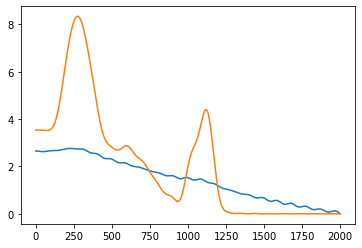

In [15]:
plt.plot(x_out)
plt.plot(x_true)